# A Step-by-Step Guide to Synthesizing Adversarial Examples

Synthesizing adversarial examples for neural networks is surprisingly easy: small, carefully-crafted perturbations to inputs can cause neural networks to misclassify inputs in arbitrarily chosen ways. Given that adversarial examples transfer to the physical world and can be made extremely robust, this is a real security concern.

In this post, we give a brief introduction to algorithms for synthesizing adversarial examples, and we walk through the process of implementing attacks in TensorFlow, building up to synthesizing a robust adversarial example following this technique.

This post is an executable Jupyter notebook: you’re encouraged to [download](https://colab.research.google.com/drive/12i8eqsg8goET9YB8cEU2UNsSehth6TS-?usp=sharing) it and experiment with the examples yourself!

https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/

https://locuslab.github.io/2019-03-12-provable/

Note that. This is a reproduction of the original code.

In [ ]:
Software: Python 3.7; 1.12.0 

In [264]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import PIL
import numpy as np

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

## Setup

We choose to attack an Inception v3 network trained on ImageNet. In this section, we load a pre-trained network from the TF-slim image classification library. This part isn’t particularly interesting, so feel free to skip this section.

In [265]:
inception = models.inception_v3(pretrained=True).eval()

## Example image

We load our example image and make sure it’s classified correctly.

In [266]:
# img_path, _ = urlretrieve('https://www.anishathalye.com/media/2017/07/25/cat.jpg')
img_path, _ = urlretrieve('https://github.com/lorenz-peter/lorenz-peter.github.io/raw/master/assets/img/cat.jpg')

img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

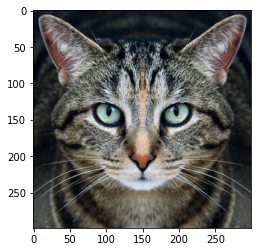

In [267]:
plt.imshow(img)

In [220]:
img.shape

(299, 299, 3)

In [221]:
tmp = img.transpose((2,0,1))

In [222]:
tmp.shape

(3, 299, 299)

In [223]:
tmp_x = np.expand_dims(tmp, axis=0)

In [224]:
torch.tensor(tmp_x).shape

torch.Size([1, 3, 299, 299])

In [225]:
probs = inception(torch.tensor(tmp_x))
probs.shape

torch.Size([1, 1000])

In [226]:
torch.argmax(probs, axis=1)

tensor([281])

In [227]:
imagenet_json, _ = urlretrieve(
    'https://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [228]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    
    tmp   = img.transpose((2,0,1))
    tmp_x = np.expand_dims(tmp, axis=0)
    
    p = np.squeeze( inception( torch.tensor(tmp_x)).detach().cpu().numpy() ) # sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    p = torch.sigmoid(torch.tensor(p)).cpu().numpy()
    # print("p: ", p)
    topk = list(p.argsort()[-10:][::-1])
    
    topprobs = p[topk]
    
    print(topprobs)
    
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

[0.99996495 0.99942195 0.99838734 0.96373767 0.94392884 0.92847806
 0.9208619  0.91081244 0.89702183 0.8681245 ]


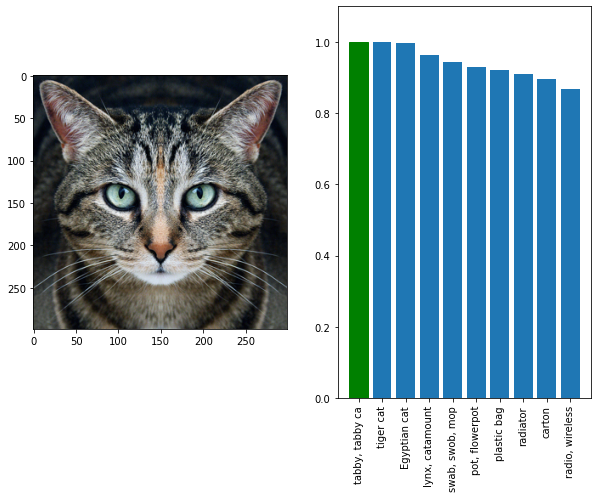

In [229]:
classify(img, correct_class=img_class)

## Adverssarial Examples

Given an image $x$, our neural network outputs a probability distribution over labsl, P(y|x). When we craft an adversarial input, we want to find an $\hat{x}$ wher $\log P(\hat{y} | \hat{x} )$ is maximized for a target label $\hat{y}$: that way our input will be misclassified as the target class. We can ensure that $\hat{x}$ does not look too different from the original $x$ by constraining ourselves to some $\ell_\infty$ box with radius $\epsilon$, requiring $||x - \hat{x} ||_\infty \leq \epsilon$. 

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using backpropagation and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{x} \leftarrow x$. Then, we repeat the following until convergence. 

1. $\hat{x} \leftarrow \hat{x} + \alpha \nabla \log P(\hat{y} | \hat{x} )$

2. $\hat{x} \leftarrow  clip(\hat{x}, x-\epsilon, x + \epsilon) $

In [230]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 10
demo_target = 924 # "guacamole"

In [231]:
img.shape

(299, 299, 3)

In [232]:
# PGD step size
alpha = 2/255
# Radius of allowable perturbations
epsilon = 8/255

X = torch.tensor( np.expand_dims( img.transpose((2,0,1)), axis=0 ) )
X_adv = X.clone().detach()

for i in range(demo_steps):
    
    # 1. Calculate gradient
    X_adv.requires_grad = True
    
    # print( inception(X_adv).shape )
    # print( torch.tensor(demo_target).shape)
    
    loss = nn.CrossEntropyLoss()( inception(X_adv), torch.tensor(np.expand_dims(demo_target, 0) ) )
    loss.backward() 
    
    # 2. Step in direction of the sign of the gradient
    X_adv.data = X_adv - alpha*torch.sign(X_adv.grad)
    
    # 3. Project onto the epsilon ball around X
    X_adv.data = torch.min(X_adv, X+epsilon)
    X_adv.data = torch.max(X_adv, X-epsilon)
    
    # 4. Restrict to space of real images
    X_adv.data = torch.clamp(X_adv, min=0, max=1)
    if i % 4 == 0: 
        print( f'[Iteration {i}] Loss: {loss.item()}' )

[Iteration 0] Loss: 9.642781257629395
[Iteration 4] Loss: 4.635489463806152
[Iteration 8] Loss: 0.09478305280208588


In [233]:
x_adv_star = X_adv[0].cpu().detach().numpy().transpose((1,2,0))

[0.9999901  0.9984754  0.9970897  0.9967997  0.9956722  0.99543506
 0.9946696  0.99343663 0.99176747 0.9912627 ]


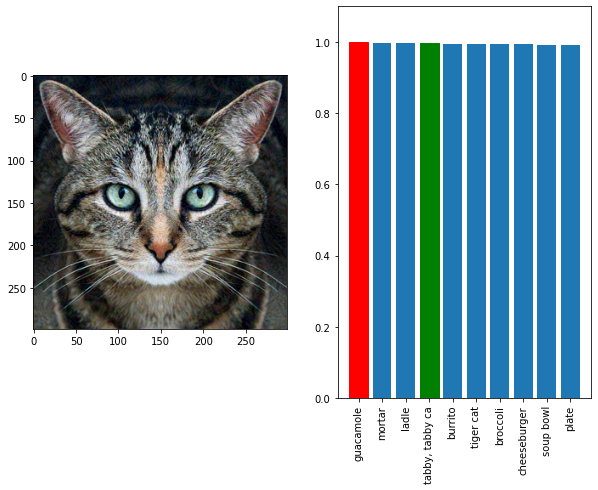

In [234]:
classify(x_adv_star, correct_class=img_class, target_class=demo_target)

# Robust adversarial examples

Now, we go through a more advanced example. We follow our approach for synthesizing robust adversarial examples to find a single perturbation of our cat image that’s simultaneously adversarial under some chosen distribution of transformations. We could choose any distribution of differentiable transformations; in this post, we’ll synthesize a single adversarial input that’s robust to rotation by $\theta \in [-\pi/4, \pi /4]$.

Before we proceed, let’s check if our previous example is still adversarial if we rotate it, say by an angle of $\theta = \pi/8.$

In [235]:
ex_angle = np.pi/8
rotated = T.functional.rotate(X, angle=22.5)
rotated.shape

torch.Size([1, 3, 299, 299])

In [236]:
X.shape

torch.Size([1, 3, 299, 299])

In [237]:
im_rotate = rotated.cpu().detach().numpy()[0].transpose( (1,2,0) )

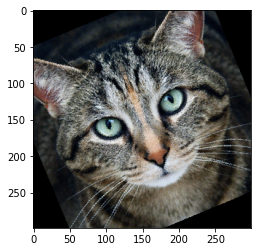

In [238]:
plt.imshow(im_rotate)

In [239]:
x_adv_star.shape

(299, 299, 3)

In [240]:
x_adv_rot = np.expand_dims(x_adv_star.transpose((2,0,1)), 0)

In [241]:
x_adv_rot.shape

(1, 3, 299, 299)

In [242]:
rotated2 = T.functional.rotate(torch.tensor(x_adv_rot), angle=22.5)

In [243]:
rotated2.shape

torch.Size([1, 3, 299, 299])

In [244]:
x_adv_rot.dtype

dtype('float32')

In [245]:
x_adv_rot[0].shape

(3, 299, 299)

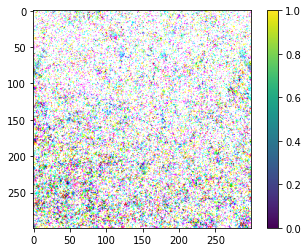

In [246]:
pix_diff = np.abs(x_adv_rot[0]-np.array(X[0])).transpose(1, 2, 0)
pix_diff *= 1 / np.max(pix_diff)
plt.imshow(pix_diff); plt.colorbar()

[0.9999901  0.9984754  0.9970897  0.9967997  0.9956722  0.99543506
 0.9946696  0.99343663 0.99176747 0.9912627 ]


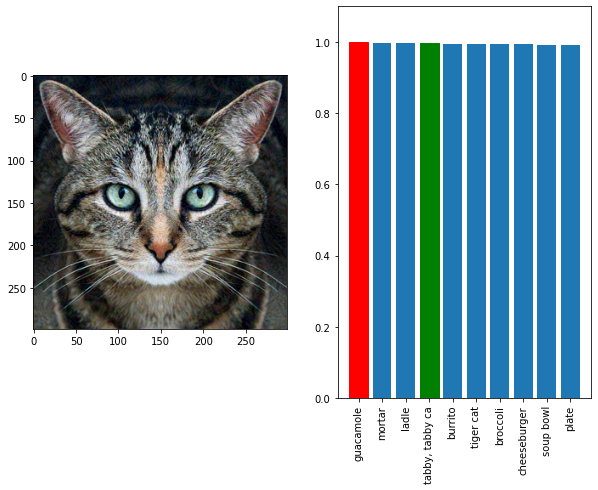

In [247]:
classify(x_adv_rot[0].transpose((1,2,0)), correct_class=img_class, target_class=demo_target)

In [248]:
im_rotate.shape

(299, 299, 3)

[0.9999187  0.99833053 0.99721766 0.9815678  0.9740621  0.9610419
 0.9495665  0.90993434 0.9012014  0.90091723]


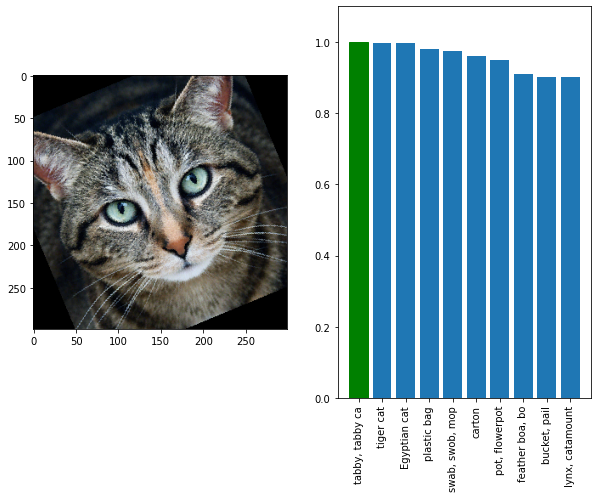

In [249]:
classify(im_rotate, correct_class=img_class, target_class=demo_target)

Looks like our original adversarial example is not rotation-invariant!

So, how do we make an adversarial example robust to a distribution of transformations? Given some distribution of transformations $T$, we can maximize $E_{t ~ T} \log P(\hat{y} | t(\hat{x}))$, subject to $||x - \hat{x}||_{infty} \leq \epsilon$. We can solve this optimization problem via projected gradient descent (PGD), noting that  $\nabla E_{t ~ T} \log P (\hat{y} | t(\hat{x}))$ is $E_{t ~ T} \nabla \log P (\hat{y} | t(\hat{x}))$ and approximating with samples at each gradient descent step.

Rather than manually implementing the gradient sampling, we can use a trick to get TensorFlow to do it for us: we can model our sampling-based gradient descent as doing gradient descent over an ensemble of stochastic classifiers that randomly sample from the distribution and transform their input before classifying it.

In [254]:
# PGD step size
alpha = 2/255
# Radius of allowable perturbations
epsilon = 8/255
steps = 10

X_rot = torch.tensor( np.expand_dims( im_rotate.transpose((2,0,1)), axis=0 ) )
X_rot_adv = X_rot.clone().detach()

for i in range(steps):
    
    # 1. Calculate gradient
    X_rot_adv.requires_grad = True
    
    loss = nn.CrossEntropyLoss()( inception(X_rot_adv), torch.tensor(np.expand_dims(demo_target, 0) ) )
    loss.backward() 
    
    # 2. Step in direction of the sign of the gradient
    X_rot_adv.data = X_rot_adv - alpha*torch.sign(X_rot_adv.grad)
    
    # 3. Project onto the epsilon ball around X
    X_rot_adv.data = torch.min(X_rot_adv, X_rot+epsilon)
    X_rot_adv.data = torch.max(X_rot_adv, X_rot-epsilon)
    
    # 4. Restrict to space of real images
    X_rot_adv.data = torch.clamp(X_rot_adv, min=0, max=1)
    if i % 4 == 0: 
        print( f'[Iteration {i}] Loss: {loss.item()}' )

[Iteration 0] Loss: 8.613812446594238
[Iteration 4] Loss: 2.3530797958374023
[Iteration 8] Loss: 0.17021040618419647


In [257]:
X_rot_adv.shape

torch.Size([1, 3, 299, 299])

In [260]:
X_rot_adv_np = X_rot_adv[0].cpu().detach().numpy()

In [262]:
X_rot_adv_np = X_rot_adv_np.transpose( (1,2,0) )

[0.9999844  0.998494   0.997428   0.9959454  0.99590576 0.9934517
 0.9927159  0.9886607  0.98855746 0.98751384]


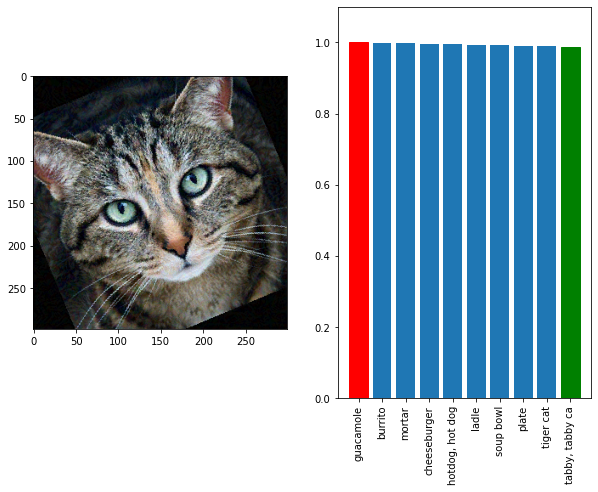

In [263]:
classify(X_rot_adv_np, correct_class=img_class, target_class=demo_target)